In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------

In [2]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
jensen2005 = dict()
jensen2005['E125'] = dict()
jensen2005['E500'] = dict()

# Axons
jensen2005['E125']['axon'] = np.array([0.10000, 2.99614, 0.19835, 1.59634, 0.49824,
                                   0.72339, 1.00000, 0.54247, 2.00708, 0.48697,
                                   5.04155, 0.46555, 10.00000, 0.46976, 20.30918,
                                   0.46976, 50.41550, 0.46555]).reshape((-1, 2))
jensen2005['E125']['axon'][:, 0] /= 1000.0  # convert ms to s

jensen2005['E500']['axon'] = np.array([0.09883, 20.86371, 0.19535, 8.69288, 0.48840,
                                   4.50809, 0.98832, 2.93549, 1.90815, 2.31750,
                                   4.88400, 2.19890, 9.54095, 2.08637, 19.08149,
                                   2.06818, 47.70583, 1.99701]).reshape((-1, 2))
jensen2005['E500']['axon'][:, 0] /= 1000.0  # from ms to s


# SL cells
# The SL cell responses were typically a single action potential, although a few cells elicited
# a second action potential that immediately followed the first.
jensen2005['E125']['SL'] = np.array([0.10239, 0.74318, 0.19372, 0.62082, 0.49824,
                                 0.46976, 1.00000, 0.37855, 1.96023, 0.39954,
                                 5.04155, 0.40679, 10.00000, 0.39954, 19.83517,
                                 0.39242, 49.82369, 0.35866]).reshape((-1, 2))
jensen2005['E125']['SL'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500']['SL'] = np.array([0.09883, 6.86281, 0.20000, 4.50809, 0.47706,
                                 2.83447, 0.98832, 2.01457, 1.93070, 2.05016,
                                 4.77058, 1.99701, 9.54095, 2.01457, 19.08149,
                                 1.97960, 47.14866, 1.87830]).reshape((-1, 2))
jensen2005['E500']['SL'][:, 0] /= 1000.0  # from ms to s


# LL cells
# The LL cell responses consisted of one or more bursts of typically two to five action potentials
# after stimulation at or slightly above threshold current. Unlike the SL cell responses, the
# LL cell responses did not appear to be due to direct activation of RGCs but rather to
# presynaptic activation of retinal neurons.
# LL (delayed) responses have higher thresholds than SL (immediate) responses.
jensen2005['E125']['LL'] = np.array([0.09767, 15.26138, 0.19835, 9.13982, 0.49824,
                                 4.78286, 0.98826, 3.02321, 1.96023, 2.01691,
                                 4.92388, 0.93057, 10.00000, 0.67317, 19.60233,
                                 0.35227, 49.82369, 0.28133]).reshape((-1, 2))
jensen2005['E125']['LL'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500']['LL'] = np.array([0.09883, 53.70788, 0.20000, 36.53740, 0.48840, 
                                 12.23073, 0.96537, 8.76932, 1.90815, 6.39858,
                                 4.88400, 4.13019, 9.65370, 2.46397, 19.08149,
                                 1.81366, 47.70583, 0.96559]).reshape((-1, 2))
jensen2005['E500']['LL'][:, 0] /= 1000.0  # from ms to s

In [3]:
# Data extracted from Fig. 4

# Cathodic
jensen2005['E125']['cathodic'] = np.array([0.09790, 3.60377, 0.19721, 1.80616, 0.50172,
                                       0.83488, 0.98945, 0.65090, 1.99315, 0.60031,
                                       4.96424, 0.58921, 9.89445, 0.58921, 20.14408,
                                       0.58555, 51.24806, 0.58555]).reshape((-1, 2))
jensen2005['E125']['cathodic'][:, 0] /= 1000

jensen2005['E500']['cathodic'] = np.array([0.09674, 12.99098, 0.19533, 7.89559, 0.49841,
                                       4.14732, 0.98500, 2.61376, 1.98677, 1.97357,
                                       4.94956, 1.87169, 9.86591, 1.84259, 19.66889,
                                       1.74952, 48.99084, 1.73072]).reshape((-1, 2))
jensen2005['E500']['cathodic'][:, 0] /= 1000



# Anodic
jensen2005['E125']['anodic'] = np.array([0.10000, 8.94028, 0.19931, 5.57116, 0.50172,
                                     3.83516, 1.01067, 3.42874, 2.03590, 3.10379,
                                     5.01719, 3.14266, 10.21449, 3.12316, 20.35897,
                                     3.06540, 51.24806, 3.18202]).reshape((-1, 2))
jensen2005['E125']['anodic'][:, 0] /= 1000

jensen2005['E500']['anodic'] = np.array([0.09849, 26.77548, 0.19485, 13.42013, 0.49741, 6.40109, 0.98211, 4.95176,
                              1.93901, 3.87704, 4.93281, 3.90493, 9.83307, 3.79816, 20.02002, 3.76131,
                              50.94491, 3.56675]).reshape((-1, 2))
jensen2005['E500']['anodic'][:, 0] /= 1000

In [4]:
# Data extracted from Fig. 2
jensen2007 = dict()

jensen2007['amp2amp1'] = np.array([0.98021, 0.06501, 1.96095, 0.22681,
                                   2.84399, 0.60933, 3.79513, 0.61970,
                                   4.63264, 0.68464, 5.43022, 0.78494,
                                   6.42094, 0.86290, 7.32954, 0.93068,
                                   8.28541, 1.00133]).reshape((-1, 2))
jensen2007['amp2amp1'][:, 0] = 1000.0 / np.array([15, 25, 40, 65, 100, 150, 250, 400, 650])

jensen2007['norm_resp'] = dict()
jensen2007['norm_resp']['1.5'] = np.array([1.11538, 0.99233, 2.13305, 0.99832,
                                           3.13831, 1.02989, 4.15798, 1.04791,
                                           5.13079, 0.98479, 6.14069, 0.94417,
                                           7.15497, 1.02987, 8.15510, 0.93062,
                                           9.17001, 0.92007, 10.19143, 0.94861]).reshape((-1, 2))
jensen2007['norm_resp']['2.5'] = np.array([1.13180, 0.99080, 2.14320, 0.95921,
                                           3.15460, 0.92761, 4.13668, 0.92012,
                                           5.14370, 0.96221, 6.17201, 0.93210,
                                           7.14858, 0.89153, 8.15184, 0.91107,
                                           9.14658, 0.87950, 10.18642, 0.91854]).reshape((-1, 2))
jensen2007['norm_resp']['4.0'] = np.array([1.11513, 0.99083, 2.11476, 0.88857,
                                           3.13192, 0.89156, 4.13781, 0.82689,
                                           5.09947, 0.79687, 6.16888, 0.81330,
                                           7.15397, 0.82385, 8.16349, 0.88098,
                                           9.13029, 0.78178, 10.18454, 0.80727]).reshape((-1, 2))
jensen2007['norm_resp']['6.5'] = np.array([1.14871, 0.99228, 2.10348, 0.82092,
                                           3.11313, 0.77880, 4.10010, 0.70063,
                                           5.12152, 0.72917, 6.13944, 0.73666,
                                           7.09584, 0.67507, 8.15184, 0.71107,
                                           9.13969, 0.73816, 10.14182, 0.65094]).reshape((-1, 2))
jensen2007['norm_resp']['10.0'] = np.array([1.14871, 0.99228, 2.12528, 0.75172,
                                            3.11000, 0.66001, 4.08294, 0.69764,
                                            5.12290, 0.63743, 6.12415, 0.64495,
                                            7.12365, 0.64194, 8.12065, 0.62390,
                                            9.10699, 0.64197, 10.12854, 0.57126]).reshape((-1, 2))
jensen2007['norm_resp']['15.0'] = np.array([1.13180, 0.99080, 2.08056, 0.58336,
                                            3.07204, 0.53225, 4.05700, 0.44204,
                                            5.08168, 0.49013, 6.07617, 0.45705,
                                            7.07141, 0.42849, 8.07930, 0.37585,
                                            9.04924, 0.39544, 10.08231, 0.39389]).reshape((-1, 2))
jensen2007['norm_resp']['25.0'] = np.array([1.11488, 0.98933, 2.08081, 0.58487,
                                            3.06176, 0.47061, 4.06703, 0.50218,
                                            5.09985, 0.49912, 6.05988, 0.35933,
                                            7.06139, 0.36835, 8.06640, 0.39842,
                                            9.05888, 0.35332, 10.08131, 0.38787]).reshape((-1, 2))
jensen2007['norm_resp']['40.0'] = np.array([1.11463, 0.98782, 2.00100, 0.20604,
                                            3.02694, 0.46164, 4.01090, 0.16542,
                                            5.06590, 0.39541, 5.98547, 0.11283,
                                            7.07880, 0.37284, 8.03170, 0.09020,
                                            9.06502, 0.29015, 10.04610, 0.07665]).reshape((-1, 2))
jensen2007['norm_resp']['65.0'] = np.array([1.13205, 0.99231, 1.99261, 0.05568,
                                            3.01002, 0.06016, 3.98910, 0.03463,
                                            5.03069, 0.08419, 6.00852, 0.05114,
                                            7.02180, 0.13082, 8.00000, 0.00003,
                                            9.00601, 0.03611, 10.01942, 0.01654]).reshape((-1, 2))

In [5]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

# Model
-----------------

Following are all utily funcions used in this script.

In [6]:
class GanglionCell(object):
    def __init__(self, tsample, ca_scale=1.0, ca_tau=0.0191,
                 inl_scale=0, anodic_scale=0,
                 sig_a=3.0, sig_b=8.0):
        ca_scale > 0
        inl_scale > 0
        anodic_scale > 0
        ca_tau > 0
        self.tsample = tsample
        self.ca_scale = ca_scale
        self.ca_tau = ca_tau
        self.inl_scale = inl_scale
        self.anodic_scale = anodic_scale
        self.sig_a = sig_a
        self.sig_b = sig_b

        self.tau_gcl = 0.42 / 1000
        t = np.arange(0, 6 * self.tau_gcl, self.tsample)
        self.gamma_gcl = e2cm.gamma(1, self.tau_gcl, t)
        self.gamma_gcl /= np.trapz(self.gamma_gcl, dx=self.tsample)
        
        self.tau_inl = 18.0 / 1000
        self.delay_inl = 40.0 / 1000
        t = np.arange(0, 10 * self.tau_inl, self.tsample)
        tmp_gamma = e2cm.gamma(2, self.tau_inl, t)
        delay = np.zeros(int(np.round(self.delay_inl / self.tsample)))
        t = np.concatenate((delay, t))
        self.gamma_inl = np.concatenate((delay, tmp_gamma))

        t = np.arange(0, 6 * self.ca_tau, self.tsample)
        self.gamma_ca = e2cm.gamma(1, self.ca_tau, t)
        self.gamma_ca /= np.trapz(self.gamma_ca, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        # Calculate charge accumulation on electrode
        self.stim = pt
        # TODO: what if charge accum grows slower for anodic
        self.ca = pt.tsample * fftconvolve(np.abs(pt.data), self.gamma_ca,
                                           mode='full')[:pt.data.size]

        # Calculate impulse responses for GCL and INL layers
        self.r_gcl_lin = utils.sparseconv(self.gamma_gcl, pt.data, mode='full', dojit=True)
        self.r_gcl_lin = pt.tsample * self.r_gcl_lin[:pt.data.size]
        self.r_inl_lin = utils.sparseconv(self.gamma_inl, pt.data, mode='full', dojit=True)
        self.r_inl_lin = pt.tsample * self.r_inl_lin[:pt.data.size]

        # Sum up cathodic vs anodic
        self.r_cath_lin = np.maximum(0, -self.r_gcl_lin) + self.inl_scale * np.maximum(0, -self.r_inl_lin)
        self.r_anod_lin = np.maximum(0, self.r_gcl_lin) + self.inl_scale * np.maximum(0, self.r_inl_lin)
        self.r_lin = self.r_cath_lin + self.anodic_scale * self.r_anod_lin
        
        # Adjust for accumulated charge
        self.r_adj = self.r_lin - self.ca_scale * self.ca
        
        # Feed through logistic activation function
        self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

Helper
------

In [7]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    if np.allclose(y.ptp(), 0.0):
        return np.inf

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [8]:
# Monophasic pulse train
def get_jensen2005_pt(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 20.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return utils.TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return utils.TimeSeries(tsample, pulse_train)

In [9]:
def find_sl_ll(resp, stim, delay_inl, verbose=False):
    """Finds the SL and LL responses of a pulse train"""
    
    # Find stimulus on-set in stimulus
    idx_onset = np.where(np.abs(stim.data) == np.abs(stim.data).max())[0][0]
    dur_onset = idx_onset * stim.tsample
    
    # Translate to indexing of `resp` (might have different `tsample`)
    idx_onset = int(np.floor(dur_onset / resp.tsample))
    
    if verbose:
        print('stim onset: dur=%f, idx=%d' % (dur_onset, idx_onset))
        
    activity = resp.data.squeeze()
    
    # SL response within 10ms of stimulus onset
    sl_dur = 10.0 / 1000
    sl_size = int(np.round(sl_dur / resp.tsample))
    sl_resp = activity[idx_onset: idx_onset + sl_size]
    t_sl = (sl_resp.argmax() + idx_onset) * resp.tsample
    y_sl = sl_resp.max()
    
    # LL response after ~40ms of stimulus onset
    ll_delay = int(np.floor(delay_inl / resp.tsample))
    ll_resp = activity[idx_onset + ll_delay:]
    t_ll = (ll_resp.argmax() + idx_onset + ll_delay) * resp.tsample
    y_ll = ll_resp.max()
    
    if verbose:
        print('SL=%f at t=%f, LL=%f at t=%f' % (y_sl, t_sl, y_ll, t_ll))
        
    return [t_sl, y_sl], [t_ll, y_ll]

# Fit
----------

In [10]:
def run_jensen2005_fig3(model,
                        pulse_durs=np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]) / 1000,
                        verbose=False):
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pulse_durs
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_jensen2005_pt('cathodic', stim_freq, 1.0, pulse_durs[0], stim_dur, tsample)
    mov = gcr.model_cascade(stim)
    sl_max, ll_max = find_sl_ll(mov, stim, gcr.delay_inl)
    act_sl_match = sl_max[1]
    act_ll_match = ll_max[1]
    
    fig3['act_sl_match'] = act_sl_match
    fig3['act_ll_match'] = act_ll_match

    amp_in = np.array([0.01, 0.05, 0.1, 0.5, 1.0])
    fig3['amp_in'] = amp_in
    
    if verbose:
        print('- Threshold SL=%f LL=%f' %  (act_sl_match, act_ll_match))

    amp_match_sl = []
    amp_match_ll = []
    for pd in pulse_durs:
        cond = '%.3f' % pd
        fig3[cond] = dict()

        sl_out = []
        ll_out = []
        for amp in amp_in:
            stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
            mov = gcr.model_cascade(stim)
            sl_max, ll_max = find_sl_ll(mov, stim, gcr.delay_inl)
            sl_out.append(sl_max[1])
            ll_out.append(ll_max[1])
        fig3[cond]['sl_out'] = sl_out
        fig3[cond]['ll_out'] = ll_out

        f_sl = fit_amps(amp_in, sl_out, act_sl_match)
        if np.isnan(f_sl):
            print('nan for SL=%f, sl_out=%s' % (act_sl_match, [('%.3f' % s) for s in sl_out]))
            f_sl = np.inf
            
        f_ll = fit_amps(amp_in, ll_out, act_ll_match)
        if np.isnan(f_ll):
            print('nan for LL=%f, sl_out=%s' % (act_ll_match, [('%.3f' % s) for s in ll_out]))
            f_ll = np.inf
        amp_match_sl.append(f_sl)
        amp_match_ll.append(f_ll)
        if verbose:
            print("match SL=%f LL=%f" % (amp_match_sl[-1], amp_match_ll[-1]))
        
    fig3['amp_match_sl'] = np.array(amp_match_sl)
    fig3['amp_match_ll'] = np.array(amp_match_ll)
    return fig3

In [11]:
def run_jensen2005_fig4(model, ptype,
                        pulse_durs=np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]) / 1000,
                        verbose=False):
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pulse_durs
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_jensen2005_pt(ptype, stim_freq, 1.0, pulse_durs[0], stim_dur, tsample)
    mov = gcr.model_cascade(stim)
    act_match = mov.data.max()
    amp_in = np.array([0.05, 0.1, 0.5, 1.0])
    fig4['amp_in'] = amp_in

    if verbose:
        print('- Threshold=%f' %  act_match)

    amp_match = []
    for pd in pulse_durs:
        cond = '%.3f' % pd
        fig4[cond] = dict()

        if verbose:
            print('- Processing pulse dur %f' % pd)
        act_out = []
        for amp in amp_in:
            stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
            idx_onset = stim.data.nonzero()[0][0]
            mov = gcr.model_cascade(stim)
            act_out.append(mov.data.max())
        fig4[cond]['act_out'] = act_out
        amp_match.append(fit_amps(amp_in, act_out, act_match))
        
    fig4['amp_match'] = np.array(amp_match)
    return fig4

In [12]:
def run_jensen2007_exp0(model, amp=1.0):
    # Finding threshold
    freq = 10.0
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [13]:
def run_jensen2007_exp1(model, isis):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    amp = 1.5
    num_pulses = 2
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['isis'] = isis
    exp1['freqs'] = 1000.0 / np.array(isis)
    amp2amp1 = []
    for freq in exp1['freqs']:
        cond = '%.1f' % freq
        exp1[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=idur,
                                      pulsetype='anodicfirst',
                                      delay=10.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp1[cond]['gcr'] = gcr
        exp1[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp1[cond]['resp'] = peaks
        amp2amp1.append(peaks[1] / (peaks[0] + np.finfo(float).eps))
    exp1['amp2amp1'] = amp2amp1
        
    return exp1

In [14]:
def run_jensen2007_exp2(model, freqs):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    amp = 1.5
    num_pulses = 10
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp2 = dict()
    exp2['freqs'] = freqs
    for freq in freqs:
        cond = '%.1f' % freq
        exp2[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=idur,
                                      pulsetype='anodicfirst',
                                      delay=10.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp2[cond]['gcr'] = gcr
        exp2[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp2[cond]['resp'] = peaks
        exp2[cond]['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp2

In [15]:
def run_cai2011_exp0(model, amp=1.0):
    # Finding threshold
    freq = 10.0
    pdur = 0.2 / 1000
    idur = 10.0 / 1000
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)

    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [16]:
def run_cai2011_exp1(model, freqs):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amps'] = np.arange(9)
    for freq in freqs:
        cond = '%.0f' % freq
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim)
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = np.array(resp) / 100.0
        
    return exp1

In [17]:
def mse_jensen2005_fig3(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        model = get_model(x, diam)
        fig3 = run_jensen2005_fig3(model)
        
        if np.any(np.isinf(fig3['amp_match_sl'])):
            return 1e9
        model_sl = fig3['amp_match_sl'] / (fig3['amp_match_sl'][0] + np.finfo(float).eps)
        jensen_sl = jensen2005[ename]['SL'][:, 1] / jensen2005[ename]['SL'][0, 1]
        mse += np.sum((model_sl - jensen_sl) ** 2)

        if np.any(np.isinf(fig3['amp_match_ll'])):
            return 1e9
        model_ll = fig3['amp_match_ll'] / (fig3['amp_match_ll'][0] + np.finfo(float).eps)
        jensen_ll = jensen2005[ename]['LL'][:, 1] / jensen2005[ename]['LL'][0, 1]
        mse += np.sum((model_ll - jensen_ll) ** 2)

    return mse

In [18]:
def mse_jensen2005_fig4(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        for ptype in ['cathodic', 'anodic']:
            model = get_model(x, diam)
            fig4 = run_jensen2005_fig4(model, ptype)
            if np.any(np.isinf(fig4['amp_match'])):
                return 1e9
            model_resp = fig4['amp_match'] / (fig4['amp_match'][0] + np.finfo(float).eps)
            jensen_resp = jensen2005[ename][ptype][:, 1] / jensen2005[ename][ptype][0, 1]
            mse += np.sum((model_resp - jensen_resp) ** 2)

    return mse

In [19]:
def mse_jensen2007_exp0(x):
    model = get_model(x, 40.0)
    exp0 = run_jensen2007_exp0(model)
    return np.abs(exp0['resp'] - 1.0) ** 2

In [20]:
def mse_jensen2007_exp1(x, jensen2007, isis=[15, 25, 40, 65, 100, 150, 250, 400, 650]):
    model = get_model(x, 40.0)
    exp1 = run_jensen2007_exp1(model, isis)
    return np.mean(np.abs(exp1['amp2amp1'] - jensen2007['amp2amp1'][:, 1]) ** 2)

In [21]:
def mse_jensen2007_exp2(x, jensen2007, freqs=[1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]):
    model = get_model(x, 40.0)
    exp2 = run_jensen2007_exp2(model, freqs)
    
    mse = 0
    for freq in exp2['freqs']:
        cond = '%.1f' % freq
        mse += np.mean(np.abs(exp2[cond]['norm_resp'] - jensen2007['norm_resp'][cond][:, 1]) ** 2)
    return mse

In [22]:
def mse_cai2011_exp0(x):
    model = get_model(x, 40.0)
    exp0 = run_cai2011_exp0(model)
    return np.abs(exp0['resp'] - 1.0) ** 2

In [23]:
def mse_cai2011_exp1(x, cai2011, freqs=[100.0, 200.0, 300.0]):
    model = get_model(x, 40.0)
    exp1 = run_cai2011_exp1(model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = '%.0f' % freq
        
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - cai2011[cond][:, 1]) ** 2)
    return mse

In [24]:
def mse_all(x, jensen2005, jensen2007, cai2011):
    mse = 0
    
    mse += mse_jensen2005_fig3(x, jensen2005) * 10.0
    mse += mse_jensen2005_fig4(x, jensen2005) * 10.0
    
    mse += mse_jensen2007_exp0(x) * 100.0
    mse += mse_jensen2007_exp1(x, jensen2007)
    mse += mse_jensen2007_exp2(x, jensen2007)
    
    mse += mse_cai2011_exp0(x) * 100.0
    mse += mse_cai2011_exp1(x, cai2011)
    
    print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]), mse))
    return mse

In [25]:
def get_model(x, diam):
    tsample = 0.005 / 1000

    [ca_scale, inl_scale, anodic_scale, sig_a, sig_b] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', diam / 2, -500, -500, 0.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=model['implant'][0].x_center,
                                  xhi=model['implant'][0].x_center,
                                  ylo=model['implant'][0].y_center,
                                  yhi=model['implant'][0].y_center)

    model['gcr'] = GanglionCell(tsample, ca_scale=ca_scale, inl_scale=inl_scale,
                                anodic_scale=anodic_scale, sig_a=sig_a, sig_b=sig_b)
    return model

In [26]:
res = minimize(mse_all, [1.239,  0.099,  0.433,  3.036,  6.975], args=(jensen2005, jensen2007, cai2011),
               method='L-BFGS-B', bounds=[(0.01, 10.0), (0.01, 1.0), (0.1, 5.0),
                                          (0.01, 100.0), (0.01, 50.0)])

['1.239000000', '0.099000000', '0.433000000', '3.036000000', '6.975000000']: 70.681486653
['1.239000010', '0.099000000', '0.433000000', '3.036000000', '6.975000000']: 70.681486577
['1.239000000', '0.099000010', '0.433000000', '3.036000000', '6.975000000']: 70.681486653
['1.239000000', '0.099000000', '0.433000010', '3.036000000', '6.975000000']: 70.681486659
['1.239000000', '0.099000000', '0.433000000', '3.036000010', '6.975000000']: 70.681486922
['1.239000000', '0.099000000', '0.433000000', '3.036000000', '6.975000010']: 70.681486569


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


<generator object mse_jensen2005_fig3.<locals>.<genexpr> at 0x7fcf843fed58>


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


<generator object mse_jensen2005_fig4.<locals>.<genexpr> at 0x7fcf843fed58>
['8.853740127', '0.093179234', '0.100000000', '0.010000000', '15.425928135']: 20000000204.524879456
<generator object mse_jensen2005_fig3.<locals>.<genexpr> at 0x7fcf3cdbdf68>
<generator object mse_jensen2005_fig4.<locals>.<genexpr> at 0x7fcf3cdbdf68>
['8.853740137', '0.093179234', '0.100000000', '0.010000000', '15.425928135']: 20000000204.524879456
<generator object mse_jensen2005_fig3.<locals>.<genexpr> at 0x7fcf843fed58>
<generator object mse_jensen2005_fig4.<locals>.<genexpr> at 0x7fcf843fed58>
['8.853740127', '0.093179244', '0.100000000', '0.010000000', '15.425928135']: 20000000204.524879456
<generator object mse_jensen2005_fig3.<locals>.<genexpr> at 0x7fcf3cdbdf68>
<generator object mse_jensen2005_fig4.<locals>.<genexpr> at 0x7fcf3cdbdf68>
['8.853740127', '0.093179234', '0.100000010', '0.010000000', '15.425928135']: 20000000204.524879456
<generator object mse_jensen2005_fig3.<locals>.<genexpr> at 0x7fcf84

# Plot
----------

In [27]:
# ['2.448632131', '0.172462914', '0.668644735', '0.017520115', '4.603413054']: 14.668702431
# array([ 5.22088017,  0.21807497,  1.        ,  0.15603432,  4.67154122]): 14.29895041461393
print(res)

      fun: 14.29895041461393
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.55475674e-05,   1.37051259e-02,  -5.60596369e-01,
         3.06677350e-02,  -7.62057084e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 624
      nit: 55
   status: 0
  success: True
        x: array([ 5.22088017,  0.21807497,  1.        ,  0.15603432,  4.67154122])


In [30]:
model = get_model(res.x, 40.0)
exp1 = run_cai2011_exp1(model, [100, 200, 300])

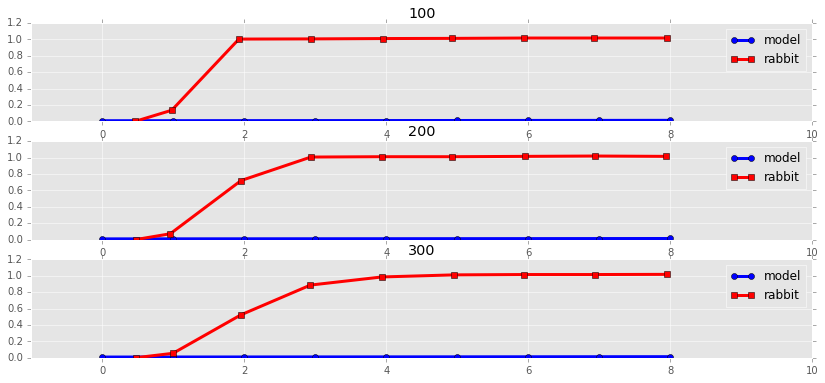

In [31]:
num_cols = np.floor(np.sqrt(len(test_freqs)))
num_rows = np.ceil(len(test_freqs) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(test_freqs):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    if 'norm_resp' in exp1[freqstr]:
        plt.plot(exp1[freqstr]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if freqstr in cai2011:
        plt.plot(cai2011[freqstr][:, 0],
                 cai2011[freqstr][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(freqstr)
#     plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

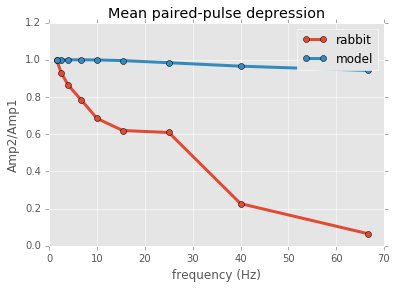

In [35]:
exp1_isis = [15, 25, 40, 65, 100, 150, 250, 400, 650]
model = get_model(res.x, 40.0)
exp1 = run_jensen2007_exp1(model, exp1_isis)
plt.plot(jensen2007['amp2amp1'][:, 0], jensen2007['amp2amp1'][:, 1], 'o-', linewidth=3, label='rabbit')
plt.plot(jensen2007['amp2amp1'][:, 0], exp1['amp2amp1'], 'o-', linewidth=3, label='model')
plt.xlabel('frequency (Hz)')
plt.ylabel('Amp2/Amp1')
plt.title('Mean paired-pulse depression')
plt.legend()

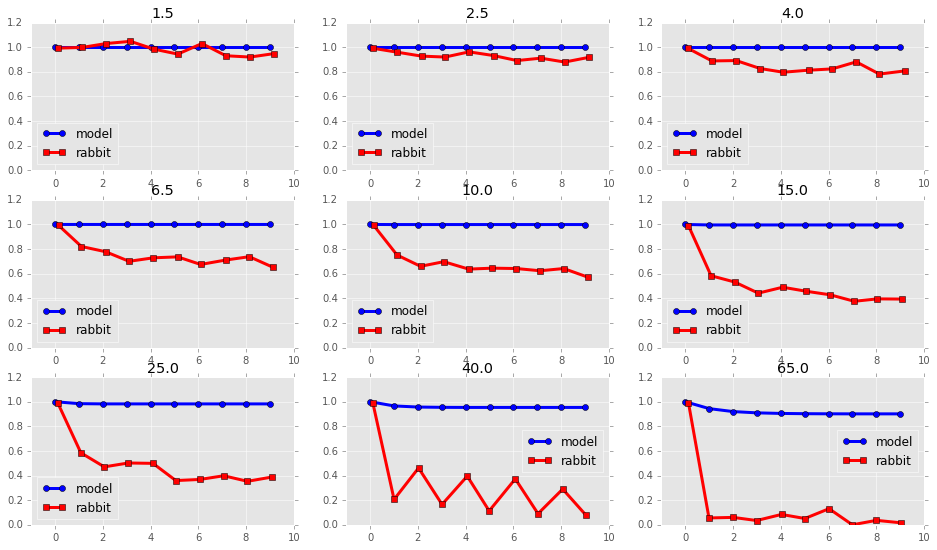

In [36]:
exp2_freqs = [1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]
exp2 = run_jensen2007_exp2(model, exp2_freqs)
num_cols = np.floor(np.sqrt(len(exp2_freqs)))
num_rows = np.ceil(len(exp2_freqs) / num_cols)
plt.figure(figsize=(16, 9))
for i, freq in enumerate(exp2_freqs):
    cond = '%.1f' % freq
    plt.subplot(num_rows, num_cols, i + 1)
    if 'norm_resp' in exp2[cond]:
        plt.plot(exp2[cond]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if cond in jensen2007['norm_resp']:
        plt.plot(jensen2007['norm_resp'][cond][:, 0] - 1,
                 jensen2007['norm_resp'][cond][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(cond)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')